In [98]:
import numpy as np
import matplotlib.pyplot as plt
import time

# try:
#     from tqdm import tqdm
# except ImportError:
#     !pip install tqdm

In [397]:
class Maze(object):
        
    staff_y = [0,60]
    staff_x = [0,10]
    bar_y = [50,60]
    bar_x = [-50,60]
    target_x = [-50,-30]
    target_y = [50,60]
    pickup_x = [40,60]
    pickup_y = [50,60]
    
    def __init__(self):
        pass
        
    def valid_x(self,x):
        if self.bar_x[0]<x<self.bar_x[1]:
            inBar_x = True
        else: inBar_x = False
        if self.staff_x[0]<x<self.staff_x[1]:
            inStaff_x = True
        else: inStaff_x = False
        return inBar_x, inStaff_x
        
    def valid_y(self,y):
        if self.bar_y[0]<y<self.bar_y[1]:
            inBar_y = True
        else: inBar_y = False
        if self.staff_y[0]<y<self.staff_y[1]:
            inStaff_y = True
        else: inStaff_y = False
        return inBar_y, inStaff_y
    
    def rough_location(self,position):
        inBar_x, inStaff_x = self.valid_x(position[0])
        inBar_y, inStaff_y = self.valid_y(position[1])
        inBar = inBar_x and inBar_y
        inStaff = inStaff_x and inStaff_y
        return inBar, inStaff
    
    def in_reward(self,position):
        if position[0]<self.target_x[1]:
            return True
        else:
            return False        
    
    def in_pickup(self,position):
        if position[0]>self.pickup_x[0]:
            return True
        else:
            return False
    
    
class Agent(object):
    
    reward = {
        'headache': -1,
        'cheese': 20
    }
    
    def __init__(self, pos = [5,0], eps = .9, numActions = 4):
        

        self.position = np.array(pos)
        self.maze = Maze()
        self.inBar = False
        self.inStaff = True
        self.alpha = False
        self.rewarded = False
        self.placeFieldSize = 5
        
        self.eps = eps
        self.gamma = 0.95
        self.eta = 0.1
        self.decayRate = 0.75
        self.rt = 0
        
        self.placeCells = self.make_places()
        self.numberIn = len(self.placeCells.T)
        self.numberOut = numActions #given as value to start with
        self.directions = 2*np.pi*np.arange(0,self.numberOut)/self.numberOut
        
        self.newActivation = np.zeros((2,self.numberIn))
        self.input_layer()
        self.oldActivation = self.newActivation
        
        self.weights = np.random.random(size=((self.numberOut,)+self.oldActivation.shape))
        self.trace = np.zeros_like(self.weights)
        
        self.newQ = None
        self.output_layer()
        self.oldQ = self.newQ

        self.newAction = None
        self.choose_action()
        self.oldAction = self.newAction
        
        self.route = []
        self.cumrew = [] #can be removed later maybe

        self.epoch_num = 0
        
    def reset(self):
        self.position = np.array([5,0])
        self.inBar = False
        self.inStaff = True
        self.alpha = False
        self.rewarded = False
        self.route = []
        self.trace = np.zeros_like(self.weights) #apparently this is important!

        
    def make_places(self, offset = 2.5, seperation = 5):
        """
        Create the centers of the place cell activity.
        
        Args:
        offset - how far from the edge the first place cell should
        seperation - the distance between adjacent centers measured in one dimension
        
        For both the staff and the bar of the T maze meshgrids are created
        (in such a way as to not overlap!) which are flattened and then h- and vstacked
        to create a 2 x #(place cells) array that stores the centers
        The offset is only taken into account on one side.
        """
        x = np.arange(self.maze.bar_x[0]+offset,self.maze.bar_x[-1],seperation)
        y = np.arange(self.maze.bar_y[0]+offset,self.maze.bar_y[-1],seperation)
        XX, YY = np.meshgrid(x,y)
        bargrid = np.vstack((XX.flatten(),YY.flatten()))
        x = np.arange(self.maze.staff_x[0]+offset,self.maze.staff_x[-1],seperation)
        y = np.arange(self.maze.staff_y[0]+offset,self.maze.bar_y[0],seperation)
        XX, YY = np.meshgrid(x,y)
        staffgrid = np.vstack((XX.flatten(),YY.flatten()))
        cells = np.hstack((bargrid,staffgrid))
        return cells
    
    def input_layer(self):
        """Compute the activation of the input layer for a given position and state and update the variable
        """
        self.newActivation[int(self.alpha)] = np.exp(-np.sum((self.placeCells.T-self.position)**2,axis=1)/(2*self.placeFieldSize**2))        
        self.newActivation[int(not self.alpha)] = 0
        
    def output_layer(self):
        self.newQ = self.weights[:,int(self.alpha)]@self.newActivation[int(self.alpha)]
#         self.newQ = np.dot(self.weights,self.newActivation.flatten())
        
    def choose_action(self):
        """
        Eps-greedy action policy
        """
        if np.random.random() < self.eps:
            self.newAction = np.random.randint(self.numberOut)
        else:
            self.newAction = self.newQ.argmax()

    def valid_move(self, newPosition):
            inBar, inStaff = self.maze.rough_location(newPosition)
            valid = inBar or inStaff
#             horizontal = self.inBar==inBar and inBar
#             vertical = self.inStaff==inStaff and inStaff
            dx = self.position[0]-newPosition[0]
            dy = self.position[1]-newPosition[1]
            
            eps = 1e-10
            if valid and dx > eps and dy>eps:
                if self.position[0]==newPosition[0]:
                    print('WARNING = {:.10f}'.format(self.position[0]-newPosition[0]))
                x, y = line_eq(self.position,newPosition)
                for xi, yi in zip(x,y):
                    inB, inS = self.maze.rough_location([xi,yi])
                    if not (inB or inS):
                        valid = False
                        break
            self.inBar = inBar
            self.inStaff = inStaff

            return valid
    
    def check_task(self):     
        if not self.alpha:
            self.alpha = self.maze.in_pickup(self.position)
        else:
            if self.maze.in_reward(self.position):
                self.rewarded = True
        return self.rewarded
    
    def move(self):
        direction = self.directions[self.newAction]
        distance = np.random.normal(loc=3,scale=1.5)
        move = np.array([np.cos(direction),np.sin(direction)]) * distance
        new_position = self.position + move
        wall = not self.valid_move(new_position)
        if not wall:
            self.position = new_position
        return wall    

    
    def trace_update(self):
        self.trace *= (self.gamma * self.decayRate)
        self.trace[self.oldAction, :] += self.oldActivation#.flatten()
        
        
    def Q_update(self):
        delta_t = self.rt + self.gamma * self.newQ[self.newAction] - self.oldQ[self.oldAction]
        delta_w = self.eta * delta_t.T * self.trace
        self.weights += delta_w
    
    def step(self, verbose = False):

        self.route.append(self.position)
        wall = self.move() 
        self.rt += self.reward['headache'] * int(wall)
        rewarded = self.check_task()        
        self.rt += self.reward['cheese'] * int(rewarded)
        
        self.input_layer() # compute newActivation
        self.output_layer()    # update newQ with (old) weights
        self.choose_action() #choose newAction
    
        if verbose:
            print('valid: ', valid)
            print('rewarded:' , rewarded)
            print('r_t: ', self.rt)

        self.trace_update()
        self.Q_update()
        
        self.oldActivation = self.newActivation
        self.oldQ = self.newQ
        self.oldAction = self.newAction
        self.cumrew.append(self.rt)
        self.rt = 0
        
        
    def trial(self, eta_decay = 0.8, plot = False):
        self.reset()
        k=0
        alpha_ = False
        aborted = False
        while not self.rewarded:
            self.step()
            if self.alpha and not alpha_:
                pickupsteps = k
#                 print(('found pickup after %.d steps'%(k)))
                alpha_ = True
            k+=1 
            if k >= int(1e5):
                aborted = True
                break
                  
#         print(('made it to target area after %.d steps'%(k)))
        
        self.eps *= eta_decay
                
        if plot:     
            route = np.asarray(self.route)
            plt.plot(route[:,0], route[:,1])
            plt.gca().set_aspect('equal')
            plt.show()
        return k, aborted
    
    def vector_fields(self,offset=1,seperation=2):
        """Generate a vector field that shows the direction with highest Q-value at each point on a grid over the maze
        offset and seperation are the same as in make_places()
        returns locations and vectors
        """
        mem_alpha = self.alpha
        locations = self.make_places(offset = offset, seperation = seperation)
        vectors = np.zeros((2,2,len(locations[0])))
        for i in range(len(locations[0])):
            self.alpha = False
            self.position = locations[:,i]
            self.input_layer()
            self.output_layer()
            a = self.newQ.argmax()
            direction = self.directions[a]
            vec = np.array([np.cos(direction), np.sin(direction)])
            vectors[0,:,i] = vec
            self.alpha = True
            self.input_layer()
            self.output_layer()
            self.choose_action()
            a = self.newQ.argmax()
            direction = self.directions[a]
            vec = np.array([np.cos(direction), np.sin(direction)])
            vectors[1,:,i] = vec
        self.alpha = mem_alpha
        return locations, vectors
        
                        
def line_eq(a,b, res = 1e4):
    x = np.linspace(a[0], b[0], int(res))
    m = (b[1]-a[1])/(b[0]-a[0])
    y = m  * (x-b[0]) + b[1]
    return x, y            

def test_place(position):
    mouse = Agent()
    mouse.position=position
    mouse.input_layer()
    cells = mouse.map
    act = mouse.newActivation[0]
    plt.scatter(cells[0],cells[1],c=act)
    plt.scatter(position[0],position[1],marker='x')
    plt.axvline(position[0])
    plt.axhline(position[1])
    plt.show()

In [411]:
mouse = Agent()

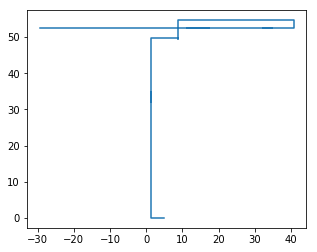

(64, False)

In [427]:
mouse.trial(plot=True)

In [429]:
def simulation(agent, n_trials = 10, n_agents = 10, num_actions = 4, eps0 = 0.9):
    latencies = np.zeros((n_agents, n_trials))
    aborts = np.ones((n_agents,n_trials))*False
    for i in range(n_agents):
        mouse = agent(eps = eps0, numActions = num_actions)
        print('mouse #',i+1)
        t0 = time.time()
        for j in range(n_trials):
            latencies[i,j], aborts[i,j] = mouse.trial()
#         print('time: %.2f' % (time.time()-t0))
#         print()
    return latencies, aborts

In [430]:
%time latencies, aborts = simulation(Agent, n_trials=20, n_agents = 20)

mouse # 1
mouse # 2
mouse # 3
mouse # 4
mouse # 5
mouse # 6
mouse # 7
mouse # 8
mouse # 9
mouse # 10
mouse # 11
mouse # 12
mouse # 13
mouse # 14
mouse # 15
mouse # 16
mouse # 17
mouse # 18
mouse # 19
mouse # 20
CPU times: user 1min 26s, sys: 44 ms, total: 1min 26s
Wall time: 1min 26s


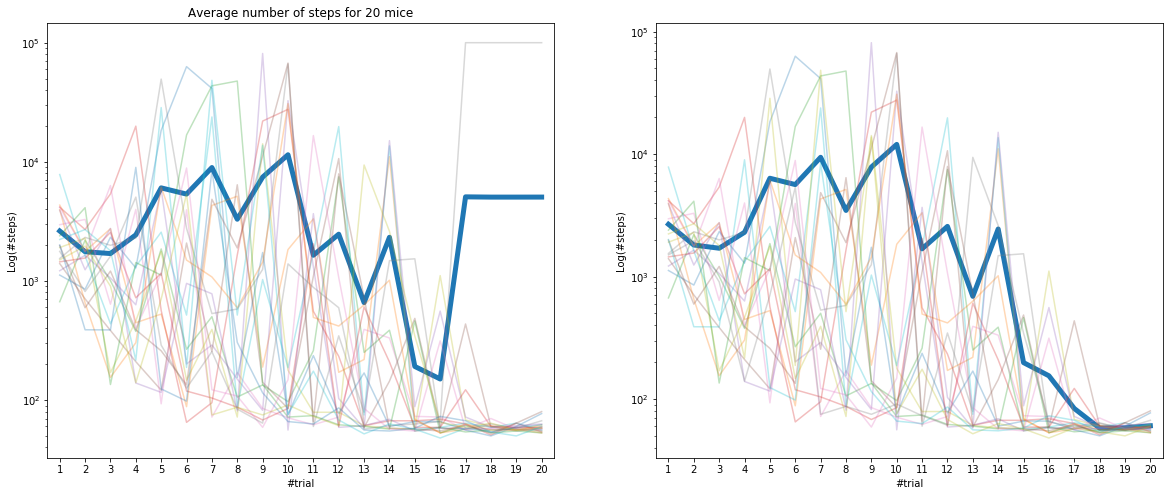

In [431]:
### plot average number of steps (over agents) vs trial number
nAgents = 20

mask = np.asarray([np.any(aborts[i])==False for i in range(len(aborts))]) #filter out mice that got stuck
fig, ax = plt.subplots(1,2,figsize=(20,8))
ax = ax.ravel()
ax[0].semilogy(np.arange(1,21),latencies.mean(axis=0),lw=5)
ax[0].set_title('Average number of steps for %.d mice'%nAgents)
for i in range(len(latencies)):
    ax[0].semilogy(np.arange(1,21),latencies[i],alpha = .3,animated=True)
if np.all(mask): #plot only succesful mice
    fig.delaxes(ax[1])
else:
    ax[1].semilogy(np.arange(1,21),latencies[mask].mean(axis=0),lw=5)
    for i in range(len(latencies[mask])):
        ax[1].semilogy(np.arange(1,21),latencies[mask][i],alpha = .3)

plt.setp(ax,xticks=np.arange(1,21),xlim=[0.5,20.5],xlabel='#trial',ylabel='Log(#steps)')
plt.show()

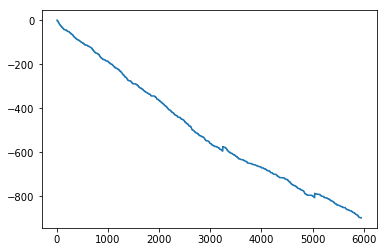

In [155]:
cumulative = np.zeros(len(mouse.cumrew))
for i in range(len(mouse.cumrew)):
    cumulative[i] = np.sum(mouse.cumrew[:i])
plt.plot(cumulative)
plt.show()

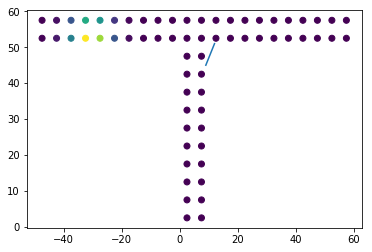

In [290]:
x, y = line_eq([9, 45], [12, 51])

cells = mouse.placeCells
act = mouse.newActivation[1]
plt.scatter(cells[0],cells[1],c=mouse.oldActivation[1])
plt.plot(x,y)
plt.show()

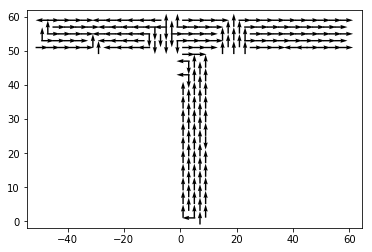

In [291]:
mouse = Agent()
vecs = vector_fields(mouse,locations)
plt.quiver(locations[0,::nth],locations[1,::nth],vecs[0,0,::nth],vecs[0,1,::nth],pivot='mid',units='y')
plt.show()

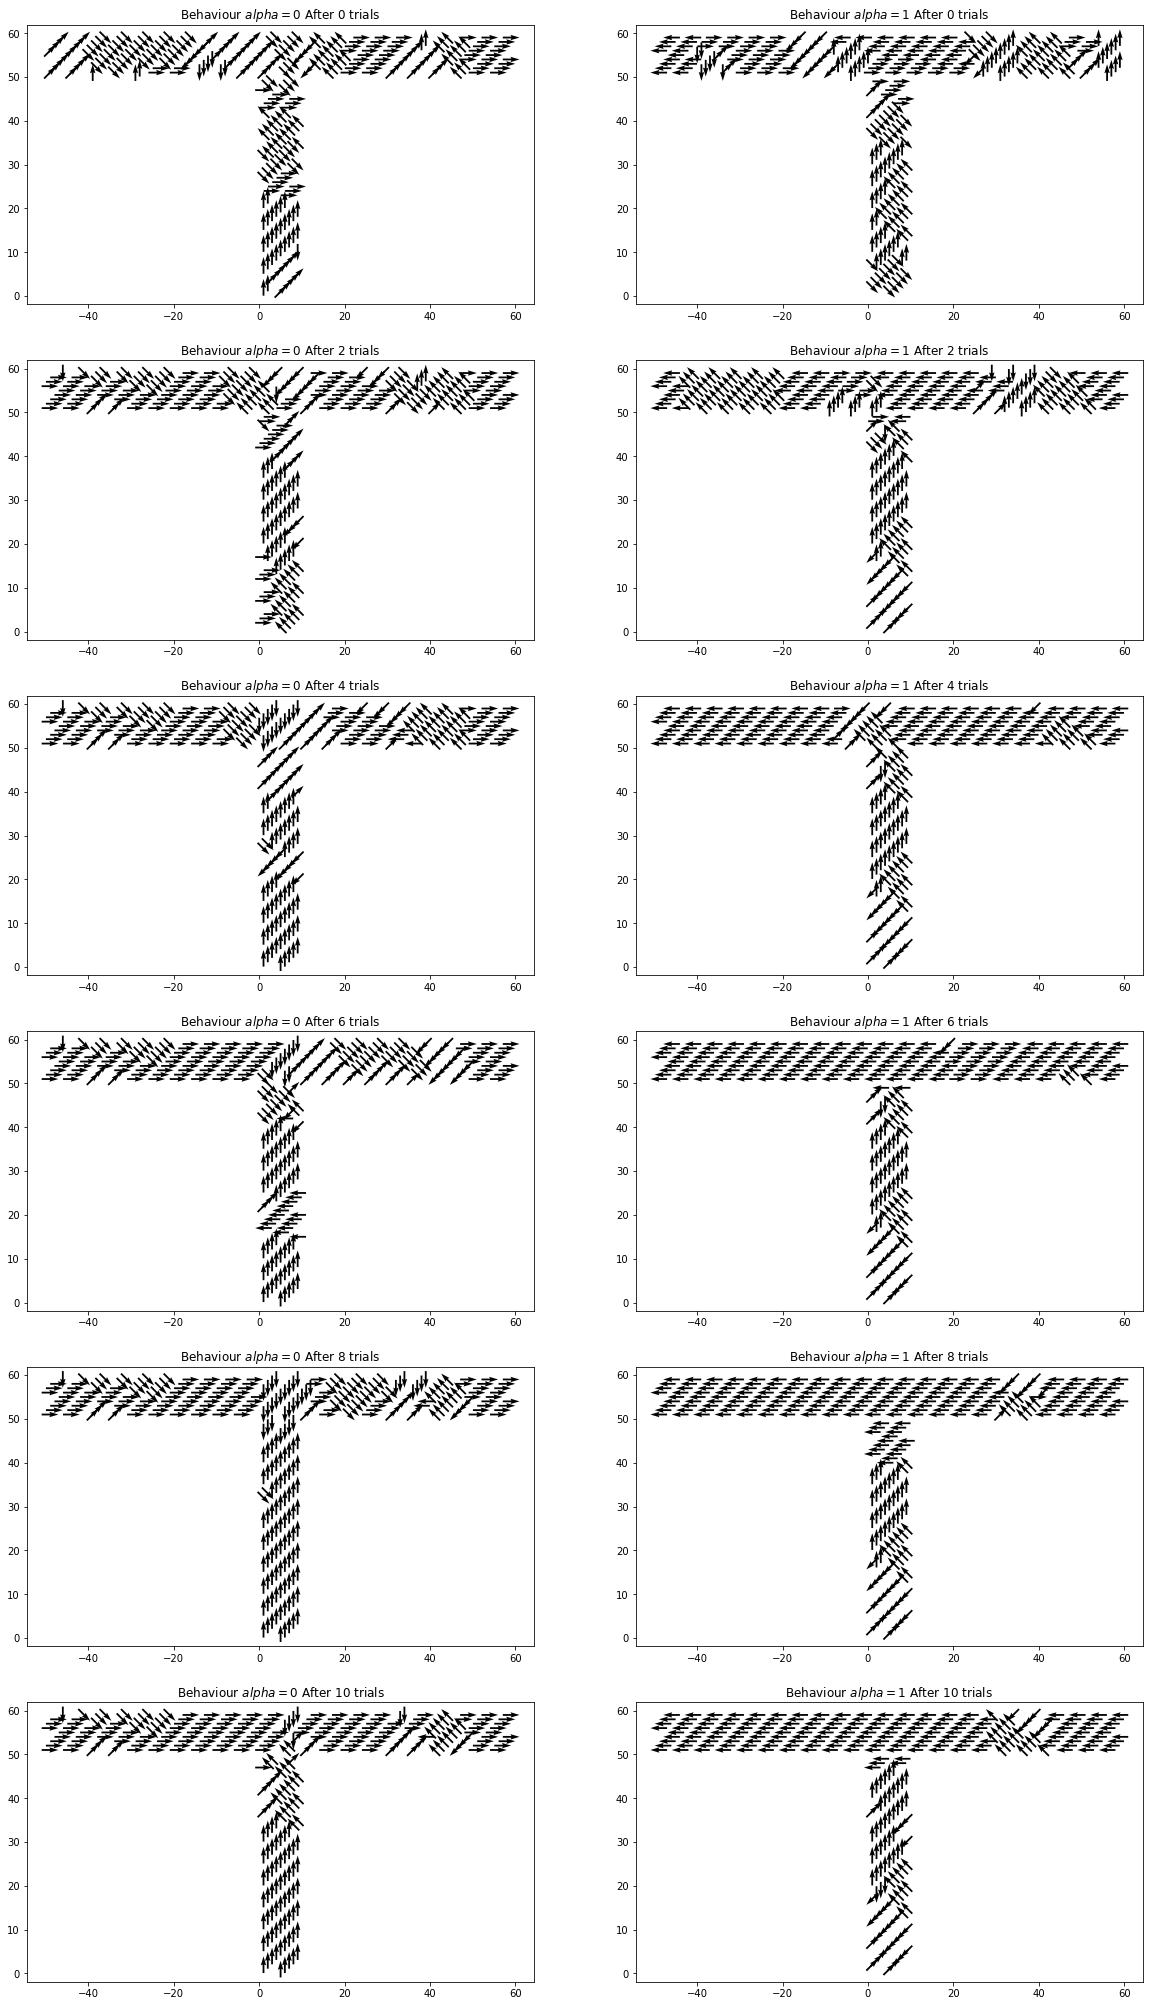

In [442]:
### this cell will our vector field function

##arguments
resolution = 1/3
seperation = 1/resolution
offset = 1 #not sure if necessary, but should be small
nTrials = 20
nth = 5 #for plotting (plot every nth vector)
nSnapshots = 5
agent = Agent(numActions=8)

locations = agent.vector_fields(seperation=1)[0]
nVecs = len(locations[0])
vectors = np.zeros((nSnapshots+1,2,2,nVecs))

k = 0     
for j in range(nTrials):    
    if j%int(nTrials/nSnapshots)==0:
        vectors[k] = agent.vector_fields(seperation=1)[1]
        k+=1
    agent.trial();
vectors[-1] = agent.vector_fields(seperation=1)[1]

fig, ax = plt.subplots(nSnapshots+1,2,figsize=(20,36))
for j in range(nSnapshots+1):
    ax[j,0].quiver(locations[0,::nth],locations[1,::nth],vectors[j,0,0,::nth],vectors[j,0,1,::nth],pivot='mid',units='y')
    ax[j,0].set_title('Behaviour $alpha = 0$ After %.d trials'%(int(nTrials/nSnapshots)*j))
    ax[j,1].quiver(locations[0,::nth],locations[1,::nth],vectors[j,1,0,::nth],vectors[j,1,1,::nth],pivot='mid',units='y')
    ax[j,1].set_title('Behaviour $alpha = 1$ After %.d trials'%(int(nTrials/nSnapshots)*j))
plt.show()